In [7]:
!pip install --upgrade pip
!pip install pandas==2.0.3
!pip install transformer-lens==1.12.0 einops tqdm plotly scikit-learn


  Using cached pandas-2.0.3.tar.gz (5.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pandas: filename=pandas-2.0.3-cp312-cp312-linux_x86_64.whl size=42828435 sha256=00963ed683d34e54beb38b3f567aabd8d7ece04dfc63257902d7165bbb46b53b
  Stored in directory: /root/.cache/pip/wheels/08/95/b7/15a2a9958c1fde0807c23b05bfed1a32ff9c7225c55d270d27
Successfully built pandas
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.0.3 which is incompatible.
spopt 0.7.0 requires pandas>=2.1.0, but you have pandas 2.0.3 which is incompatible.
inequality 1.1.2 re

In [ ]:
import os, sys

print("⚠️ IMPORTANT: Restarting Python runtime now...")
os._exit(0)


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformer_lens import HookedTransformer, HookedTransformerConfig
from sklearn.decomposition import PCA

torch.set_printoptions(sci_mode=False, precision=4)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

P = 113
EQ_TOKEN = P
SEED = 999

def set_seed(seed=SEED):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()


Device: cuda


In [6]:
def build_addition_pairs(p=P):
    pairs = [(a, b) for a in range(p) for b in range(p)]
    rng = np.random.default_rng(SEED)
    rng.shuffle(pairs)
    return pairs

pairs_add = build_addition_pairs(P)
train_frac = 0.30
train_size = int(train_frac * len(pairs_add))
train_pairs_add = pairs_add[:train_size]
test_pairs_add  = pairs_add[train_size:]

def make_add_dataset(pair_list, p=P):
    X, Y = [], []
    for a, b in pair_list:
        X.append([a, b, EQ_TOKEN])   # a, b, "="
        Y.append((a + b) % p)
    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    return X.to(device), Y.to(device)

train_X_add, train_Y_add = make_add_dataset(train_pairs_add)
test_X_add,  test_Y_add  = make_add_dataset(test_pairs_add)

print("Train:", train_X_add.shape, "Test:", test_X_add.shape)


Train: torch.Size([3830, 3]) Test: torch.Size([8939, 3])


In [7]:
cfg = HookedTransformerConfig(
    n_layers = 1,
    n_heads = 4,
    d_model = 128,
    d_head = 32,
    d_mlp = 512,
    act_fn = "relu",
    normalization_type = None,   # NO LayerNorm
    d_vocab = P + 1,             # 0..P-1 plus "="
    d_vocab_out = P,             # outputs only 0..P-1
    n_ctx = 3,
    init_weights = True,
    seed = SEED,
    device = device
)

model_add = HookedTransformer(cfg).to(device)

# Freeze all biases
for name, param in model_add.named_parameters():
    if "bias" in name:
        param.requires_grad = False

sum_params = sum(p.numel() for p in model_add.parameters())
print("Total params:", sum_params)


Moving model to device:  cuda
Total params: 227313


In [8]:
def high_precision_ce(logits, targets, num_classes=P):
    """
    Manual cross-entropy in float64 to avoid slingshotting.
    logits: [..., C] for C=num_classes
    targets: [...]
    """
    logits = logits.to(torch.float64)
    log_probs = logits - torch.logsumexp(logits, dim=-1, keepdim=True)
    one_hot = F.one_hot(targets, num_classes=num_classes).to(torch.float64)
    loss = -(one_hot * log_probs).sum(dim=-1).mean()
    return loss


In [9]:
EPOCHS = 12000           # increase if needed to see clear grokking jump
BATCH_SIZE = len(train_X_add)   # full batch (small dataset)

optimizer = torch.optim.AdamW(
    model_add.parameters(),
    lr=1e-3,
    betas=(0.9, 0.98),
    weight_decay=1.0
)

train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in tqdm(range(EPOCHS)):
    model_add.train()

    logits = model_add(train_X_add)[:, -1, :]      # prediction at last token
    loss = high_precision_ce(logits, train_Y_add)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        model_add.eval()
        # Train metrics
        train_pred = logits.argmax(dim=-1)
        train_acc = (train_pred == train_Y_add).float().mean().item()

        # Test metrics
        test_logits = model_add(test_X_add)[:, -1, :]
        test_loss = high_precision_ce(test_logits, test_Y_add)
        test_pred = test_logits.argmax(dim=-1)
        test_acc = (test_pred == test_Y_add).float().mean().item()

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1:5d} | "
              f"Train Loss {loss.item():.4f} Acc {train_acc:.3f} | "
              f"Test Loss {test_loss.item():.4f} Acc {test_acc:.3f}")


  4%|▍         | 504/12000 [00:16<04:34, 41.90it/s]

Epoch   500 | Train Loss 0.0011 Acc 1.000 | Test Loss 25.3284 Acc 0.005


  8%|▊         | 1005/12000 [00:31<05:20, 34.27it/s]

Epoch  1000 | Train Loss 0.0000 Acc 1.000 | Test Loss 33.3839 Acc 0.005


 13%|█▎        | 1506/12000 [00:45<04:01, 43.51it/s]

Epoch  1500 | Train Loss 0.0000 Acc 1.000 | Test Loss 37.2238 Acc 0.006


 17%|█▋        | 2006/12000 [01:00<04:31, 36.81it/s]

Epoch  2000 | Train Loss 0.0000 Acc 1.000 | Test Loss 36.0820 Acc 0.006


 21%|██        | 2506/12000 [01:15<03:48, 41.52it/s]

Epoch  2500 | Train Loss 0.0000 Acc 1.000 | Test Loss 35.0737 Acc 0.006


 25%|██▌       | 3006/12000 [01:31<03:12, 46.74it/s]

Epoch  3000 | Train Loss 0.0000 Acc 1.000 | Test Loss 34.1767 Acc 0.007


 29%|██▉       | 3508/12000 [01:46<03:06, 45.51it/s]

Epoch  3500 | Train Loss 0.0000 Acc 1.000 | Test Loss 33.3410 Acc 0.008


 33%|███▎      | 4007/12000 [02:00<02:53, 46.08it/s]

Epoch  4000 | Train Loss 0.0000 Acc 1.000 | Test Loss 32.5594 Acc 0.008


 38%|███▊      | 4509/12000 [02:15<02:41, 46.35it/s]

Epoch  4500 | Train Loss 0.0000 Acc 1.000 | Test Loss 31.7914 Acc 0.007


 42%|████▏     | 5004/12000 [02:31<04:44, 24.60it/s]

Epoch  5000 | Train Loss 0.0000 Acc 1.000 | Test Loss 31.0145 Acc 0.008


 46%|████▌     | 5503/12000 [02:46<03:43, 29.13it/s]

Epoch  5500 | Train Loss 0.0000 Acc 1.000 | Test Loss 30.2124 Acc 0.009


 50%|█████     | 6003/12000 [03:02<03:32, 28.26it/s]

Epoch  6000 | Train Loss 0.0000 Acc 1.000 | Test Loss 29.4519 Acc 0.010


 54%|█████▍    | 6505/12000 [03:24<03:32, 25.88it/s]

Epoch  6500 | Train Loss 0.0000 Acc 1.000 | Test Loss 28.6545 Acc 0.011


 58%|█████▊    | 7005/12000 [03:37<01:40, 49.47it/s]

Epoch  7000 | Train Loss 0.0000 Acc 1.000 | Test Loss 27.8390 Acc 0.013


 63%|██████▎   | 7509/12000 [03:47<01:31, 49.30it/s]

Epoch  7500 | Train Loss 0.0000 Acc 1.000 | Test Loss 27.0482 Acc 0.014


 67%|██████▋   | 8005/12000 [03:57<01:20, 49.35it/s]

Epoch  8000 | Train Loss 0.0000 Acc 1.000 | Test Loss 26.2595 Acc 0.016


 71%|███████   | 8507/12000 [04:07<01:10, 49.59it/s]

Epoch  8500 | Train Loss 0.0000 Acc 1.000 | Test Loss 25.5407 Acc 0.018


 75%|███████▌  | 9005/12000 [04:17<01:00, 49.51it/s]

Epoch  9000 | Train Loss 0.0000 Acc 1.000 | Test Loss 24.8350 Acc 0.021


 79%|███████▉  | 9508/12000 [04:28<00:50, 49.55it/s]

Epoch  9500 | Train Loss 0.0000 Acc 1.000 | Test Loss 24.2013 Acc 0.022


 83%|████████▎ | 10009/12000 [04:38<00:40, 49.41it/s]

Epoch 10000 | Train Loss 0.0000 Acc 1.000 | Test Loss 23.5876 Acc 0.025


 88%|████████▊ | 10509/12000 [04:48<00:30, 49.31it/s]

Epoch 10500 | Train Loss 0.0000 Acc 1.000 | Test Loss 23.0283 Acc 0.027


 92%|█████████▏| 11007/12000 [04:58<00:21, 46.91it/s]

Epoch 11000 | Train Loss 0.0000 Acc 1.000 | Test Loss 22.5278 Acc 0.028


 96%|█████████▌| 11507/12000 [05:08<00:10, 49.00it/s]

Epoch 11500 | Train Loss 0.0000 Acc 1.000 | Test Loss 22.0526 Acc 0.032


100%|██████████| 12000/12000 [05:18<00:00, 37.64it/s]

Epoch 12000 | Train Loss 0.0000 Acc 1.000 | Test Loss 21.6003 Acc 0.034


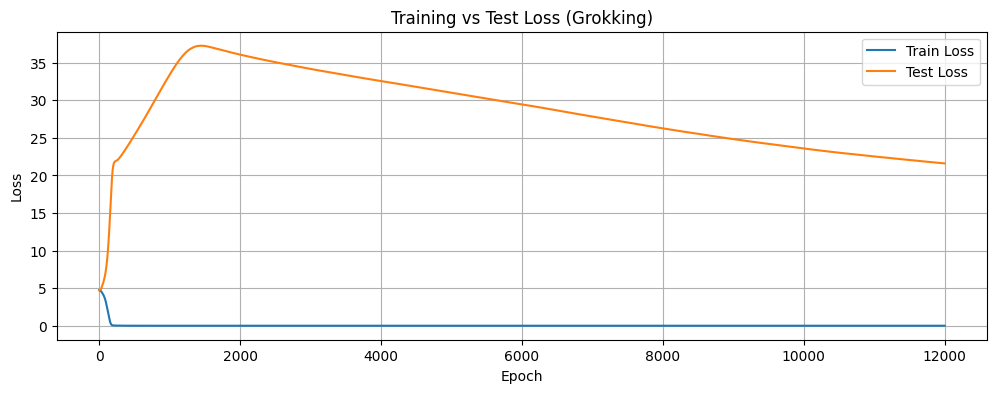

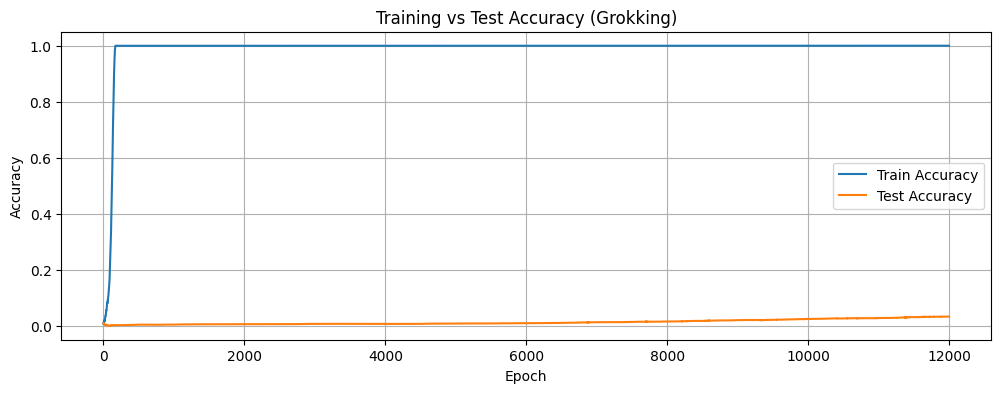

In [10]:
epochs = np.arange(1, EPOCHS + 1)

plt.figure(figsize=(12,4))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Test Loss (Grokking)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(epochs, train_accs, label="Train Accuracy")
plt.plot(epochs, test_accs, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Test Accuracy (Grokking)")
plt.legend()
plt.grid(True)
plt.show()


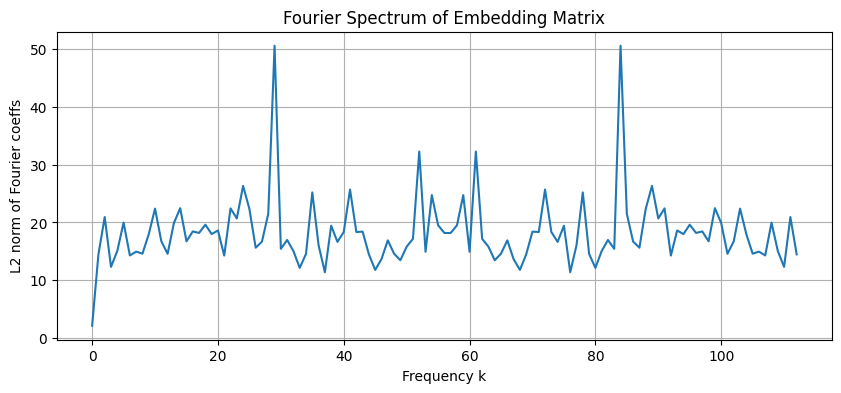

Key frequencies (largest energy): [29 52 61 84]


In [11]:
with torch.no_grad():
    WE_full = model_add.W_E.detach().cpu().numpy()  # (P+1, d_model)

WE = WE_full[:P]   # drop "=" token row, shape (P, d_model)

# DFT along vocab axis
fourier_WE = np.fft.fft(WE, axis=0)            # (P, d_model), complex
freq_magnitudes = np.linalg.norm(fourier_WE, axis=1)  # (P,)

plt.figure(figsize=(10,4))
plt.plot(freq_magnitudes)
plt.xlabel("Frequency k")
plt.ylabel("L2 norm of Fourier coeffs")
plt.title("Fourier Spectrum of Embedding Matrix")
plt.grid(True)
plt.show()

TOP_K = 4
key_freqs = freq_magnitudes.argsort()[-TOP_K:]
key_freqs = np.sort(key_freqs)
print("Key frequencies (largest energy):", key_freqs)


In [14]:
# Inspect all hook names stored in cache
sample_batch = train_X_add[:4]
_, cache = model_add.run_with_cache(sample_batch)

print("\n===== AVAILABLE KEYS IN CACHE =====\n")
for k in cache.keys():
    print(k)



===== AVAILABLE KEYS IN CACHE =====

hook_embed
hook_pos_embed
blocks.0.hook_resid_pre
blocks.0.attn.hook_q
blocks.0.attn.hook_k
blocks.0.attn.hook_v
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_pattern
blocks.0.attn.hook_z
blocks.0.hook_attn_out
blocks.0.hook_resid_mid
blocks.0.mlp.hook_pre
blocks.0.mlp.hook_post
blocks.0.hook_mlp_out
blocks.0.hook_resid_post


Attention shape: torch.Size([64, 4, 3, 3])
MLP pre-activations shape: torch.Size([64, 3, 512])


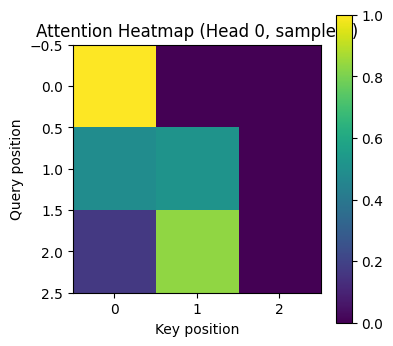

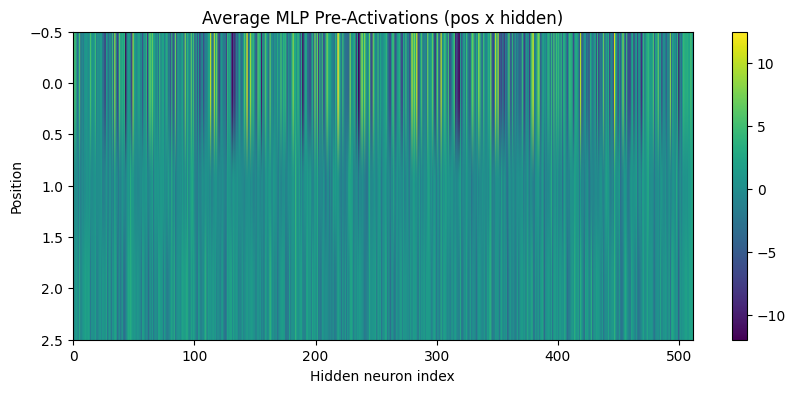

In [15]:
# Take a small sample batch
sample_batch = train_X_add[:64]

# Run with cache
_, cache = model_add.run_with_cache(sample_batch)

# --- CORRECT HOOK NAMES FOR YOUR VERSION ---
attn = cache["blocks.0.attn.hook_pattern"]   # attention matrix (batch, heads, q, k)
mlp_pre = cache["blocks.0.mlp.hook_pre"]     # MLP input activations (batch, pos, d_mlp)

print("Attention shape:", attn.shape)
print("MLP pre-activations shape:", mlp_pre.shape)

# Visualize one head's attention grid
head_idx = 0
plt.figure(figsize=(4,4))
plt.imshow(attn[0, head_idx].detach().cpu().numpy(), cmap="viridis")
plt.colorbar()
plt.title(f"Attention Heatmap (Head {head_idx}, sample 0)")
plt.xlabel("Key position")
plt.ylabel("Query position")
plt.show()

# Average MLP activation over batch & positions
mlp_mean = mlp_pre.mean(dim=0).detach().cpu().numpy()  # (pos, d_mlp)
plt.figure(figsize=(10,4))
plt.imshow(mlp_mean, aspect='auto', cmap="viridis")
plt.colorbar()
plt.title("Average MLP Pre-Activations (pos x hidden)")
plt.xlabel("Hidden neuron index")
plt.ylabel("Position")
plt.show()


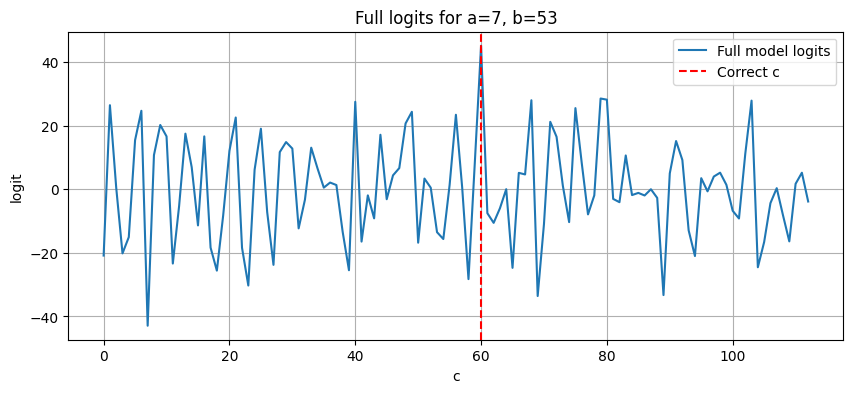

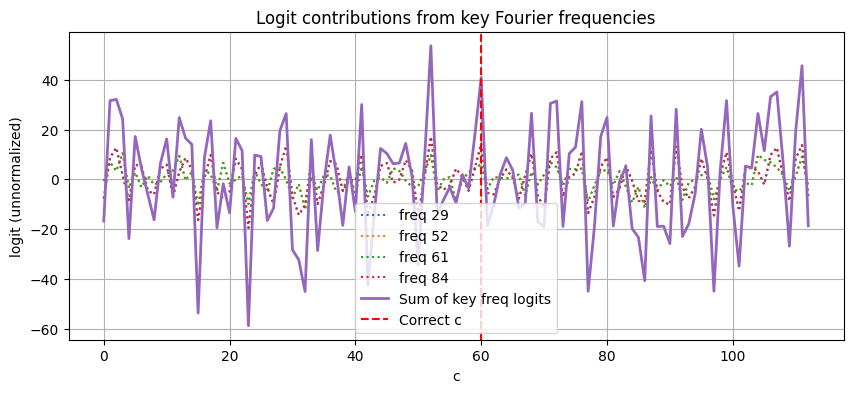

In [16]:
with torch.no_grad():
    WU = model_add.W_U.detach().cpu().numpy()   # (d_model, P)

# Helper: rebuild embedding with only selected frequencies
def rebuild_embedding_from_freqs(freq_list):
    mask = np.zeros(P, dtype=bool)
    mask[freq_list] = True
    filtered = np.where(mask[:, None], fourier_WE, 0)
    WE_filtered = np.fft.ifft(filtered, axis=0).real   # (P, d_model)
    # Put back "=" token row as original
    WE_full_new = WE_full.copy()
    WE_full_new[:P] = WE_filtered
    return torch.tensor(WE_full_new, dtype=torch.float32, device=device)

# Choose a single (a, b) to inspect
a_inspect, b_inspect = 7, 53
x_inspect = torch.tensor([[a_inspect, b_inspect, EQ_TOKEN]], device=device)

# Baseline full logits
with torch.no_grad():
    full_logits = model_add(x_inspect)[0, -1, :].detach().cpu().numpy()

plt.figure(figsize=(10,4))
plt.plot(full_logits, label="Full model logits")
plt.axvline((a_inspect + b_inspect) % P, color="r", linestyle="--", label="Correct c")
plt.legend()
plt.title(f"Full logits for a={a_inspect}, b={b_inspect}")
plt.xlabel("c")
plt.ylabel("logit")
plt.grid(True)
plt.show()

# Contributions from each key frequency
per_freq_logits = []
for k in key_freqs:
    WE_k = rebuild_embedding_from_freqs([k])
    with torch.no_grad():
        # temporarily swap embedding
        backup = model_add.W_E.data.clone()
        model_add.W_E.data = WE_k
        logits_k = model_add(x_inspect)[0, -1, :].detach().cpu().numpy()
        model_add.W_E.data = backup
    per_freq_logits.append(logits_k)

# Plot per-frequency curves and sum
plt.figure(figsize=(10,4))
for i, k in enumerate(key_freqs):
    plt.plot(per_freq_logits[i], linestyle=":", label=f"freq {k}")

sum_logits = np.sum(per_freq_logits, axis=0)
plt.plot(sum_logits, label="Sum of key freq logits", linewidth=2)
plt.axvline((a_inspect + b_inspect) % P, color="r", linestyle="--", label="Correct c")
plt.legend()
plt.title("Logit contributions from key Fourier frequencies")
plt.xlabel("c")
plt.ylabel("logit (unnormalized)")
plt.grid(True)
plt.show()


In [17]:
# We will re-train a new model for progress logging.
set_seed()
model_prog = HookedTransformer(cfg).to(device)
for name, param in model_prog.named_parameters():
    if "bias" in name:
        param.requires_grad = False

optimizer_prog = torch.optim.AdamW(
    model_prog.parameters(),
    lr=1e-3,
    betas=(0.9, 0.98),
    weight_decay=1.0
)

EPOCHS_PROGRESS = 4000            # can increase on better GPU
LOG_EVERY = 50

prog_epochs = []
prog_restricted_losses = []
prog_excluded_losses = []
prog_train_losses = []
prog_test_losses = []

def project_embedding(WE_full_np, keep_freqs):
    WE_np = WE_full_np[:P]
    fourier = np.fft.fft(WE_np, axis=0)

    keep_mask = np.zeros(P, dtype=bool)
    keep_mask[keep_freqs] = True

    # restricted: only key freqs
    restricted_fourier = np.where(keep_mask[:, None], fourier, 0)
    restricted_WE = np.fft.ifft(restricted_fourier, axis=0).real

    # excluded: everything BUT key freqs
    excluded_fourier = np.where(~keep_mask[:, None], fourier, 0)
    excluded_WE = np.fft.ifft(excluded_fourier, axis=0).real

    # reassemble full embeddings
    WE_restricted_full = WE_full_np.copy()
    WE_excluded_full = WE_full_np.copy()
    WE_restricted_full[:P] = restricted_WE
    WE_excluded_full[:P] = excluded_WE

    return (
        torch.tensor(WE_restricted_full, dtype=torch.float32, device=device),
        torch.tensor(WE_excluded_full, dtype=torch.float32, device=device)
    )

for epoch in tqdm(range(EPOCHS_PROGRESS)):
    model_prog.train()

    logits = model_prog(train_X_add)[:, -1, :]
    loss = high_precision_ce(logits, train_Y_add)

    optimizer_prog.zero_grad()
    loss.backward()
    optimizer_prog.step()

    with torch.no_grad():
        model_prog.eval()
        test_logits = model_prog(test_X_add)[:, -1, :]
        test_loss = high_precision_ce(test_logits, test_Y_add)

    prog_train_losses.append(loss.item())
    prog_test_losses.append(test_loss.item())

    if (epoch + 1) % LOG_EVERY == 0:
        with torch.no_grad():
            WE_full_prog = model_prog.W_E.detach().cpu().numpy()
            WE_restricted, WE_excluded = project_embedding(WE_full_prog, key_freqs)

            # save and restore original embedding
            backup = model_prog.W_E.data.clone()

            # restricted loss on test
            model_prog.W_E.data = WE_restricted
            logits_res = model_prog(test_X_add)[:, -1, :]
            restricted_loss = high_precision_ce(logits_res, test_Y_add).item()

            # excluded loss on train
            model_prog.W_E.data = WE_excluded
            logits_exc = model_prog(train_X_add)[:, -1, :]
            excluded_loss = high_precision_ce(logits_exc, train_Y_add).item()

            # restore
            model_prog.W_E.data = backup

        prog_epochs.append(epoch + 1)
        prog_restricted_losses.append(restricted_loss)
        prog_excluded_losses.append(excluded_loss)

        # quick sanity print
        print(f"[Epoch {epoch+1}] Restricted Loss {restricted_loss:.4f} | Excluded Loss {excluded_loss:.4f}")


Moving model to device:  cuda


  1%|▏         | 56/4000 [00:01<01:18, 50.24it/s]

[Epoch 50] Restricted Loss 4.8046 | Excluded Loss 4.2923


  3%|▎         | 109/4000 [00:02<01:19, 48.72it/s]

[Epoch 100] Restricted Loss 5.2029 | Excluded Loss 3.1433


  4%|▍         | 155/4000 [00:03<01:18, 48.99it/s]

[Epoch 150] Restricted Loss 6.9484 | Excluded Loss 1.5249


  5%|▌         | 209/4000 [00:04<01:17, 49.16it/s]

[Epoch 200] Restricted Loss 9.7890 | Excluded Loss 1.0790


  6%|▋         | 257/4000 [00:05<01:13, 50.87it/s]

[Epoch 250] Restricted Loss 10.0765 | Excluded Loss 0.9819


  8%|▊         | 305/4000 [00:06<01:13, 50.45it/s]

[Epoch 300] Restricted Loss 10.2641 | Excluded Loss 0.9167


  9%|▉         | 359/4000 [00:07<01:11, 50.85it/s]

[Epoch 350] Restricted Loss 10.5074 | Excluded Loss 0.8713


 10%|█         | 407/4000 [00:08<01:10, 50.66it/s]

[Epoch 400] Restricted Loss 10.7743 | Excluded Loss 0.8378


 11%|█▏        | 455/4000 [00:09<01:10, 50.45it/s]

[Epoch 450] Restricted Loss 11.0467 | Excluded Loss 0.8144


 13%|█▎        | 509/4000 [00:10<01:08, 50.93it/s]

[Epoch 500] Restricted Loss 11.3324 | Excluded Loss 0.7978


 14%|█▍        | 557/4000 [00:11<01:07, 50.75it/s]

[Epoch 550] Restricted Loss 11.6261 | Excluded Loss 0.7881


 15%|█▌        | 605/4000 [00:11<01:07, 49.97it/s]

[Epoch 600] Restricted Loss 11.9213 | Excluded Loss 0.7855


 16%|█▋        | 659/4000 [00:13<01:05, 50.66it/s]

[Epoch 650] Restricted Loss 12.2145 | Excluded Loss 0.7877


 18%|█▊        | 707/4000 [00:13<01:05, 50.38it/s]

[Epoch 700] Restricted Loss 12.5027 | Excluded Loss 0.7926


 19%|█▉        | 756/4000 [00:14<01:05, 49.16it/s]

[Epoch 750] Restricted Loss 12.8128 | Excluded Loss 0.8017


 20%|██        | 807/4000 [00:15<01:06, 48.04it/s]

[Epoch 800] Restricted Loss 13.1319 | Excluded Loss 0.8139


 22%|██▏       | 860/4000 [00:17<01:02, 50.50it/s]

[Epoch 850] Restricted Loss 13.4475 | Excluded Loss 0.8276


 23%|██▎       | 908/4000 [00:17<01:01, 50.27it/s]

[Epoch 900] Restricted Loss 13.7640 | Excluded Loss 0.8422


 24%|██▍       | 956/4000 [00:18<01:00, 50.32it/s]

[Epoch 950] Restricted Loss 14.0800 | Excluded Loss 0.8564


 25%|██▌       | 1010/4000 [00:19<00:59, 50.21it/s]

[Epoch 1000] Restricted Loss 14.3954 | Excluded Loss 0.8719


 26%|██▋       | 1058/4000 [00:20<00:58, 50.07it/s]

[Epoch 1050] Restricted Loss 14.7167 | Excluded Loss 0.8873


 28%|██▊       | 1106/4000 [00:21<00:57, 50.15it/s]

[Epoch 1100] Restricted Loss 15.0173 | Excluded Loss 0.8996


 29%|██▉       | 1160/4000 [00:22<00:55, 50.91it/s]

[Epoch 1150] Restricted Loss 15.3027 | Excluded Loss 0.9128


 30%|███       | 1208/4000 [00:23<00:55, 50.00it/s]

[Epoch 1200] Restricted Loss 15.5511 | Excluded Loss 0.9249


 31%|███▏      | 1256/4000 [00:24<00:54, 49.93it/s]

[Epoch 1250] Restricted Loss 15.7654 | Excluded Loss 0.9354


 33%|███▎      | 1310/4000 [00:25<00:53, 50.00it/s]

[Epoch 1300] Restricted Loss 15.9481 | Excluded Loss 0.9439


 34%|███▍      | 1358/4000 [00:26<00:53, 49.14it/s]

[Epoch 1350] Restricted Loss 16.0885 | Excluded Loss 0.9519


 35%|███▌      | 1409/4000 [00:27<00:55, 46.81it/s]

[Epoch 1400] Restricted Loss 16.1874 | Excluded Loss 0.9578


 36%|███▋      | 1452/4000 [00:29<01:47, 23.62it/s]

[Epoch 1450] Restricted Loss 16.2535 | Excluded Loss 0.9631


 38%|███▊      | 1504/4000 [00:31<01:47, 23.15it/s]

[Epoch 1500] Restricted Loss 16.2970 | Excluded Loss 0.9689


 39%|███▉      | 1555/4000 [00:33<01:37, 25.14it/s]

[Epoch 1550] Restricted Loss 16.3107 | Excluded Loss 0.9727


 40%|████      | 1604/4000 [00:35<01:31, 26.07it/s]

[Epoch 1600] Restricted Loss 16.3193 | Excluded Loss 0.9763


 42%|████▏     | 1660/4000 [00:37<00:56, 41.61it/s]

[Epoch 1650] Restricted Loss 16.3138 | Excluded Loss 0.9820


 43%|████▎     | 1707/4000 [00:38<00:48, 47.44it/s]

[Epoch 1700] Restricted Loss 16.3073 | Excluded Loss 0.9853


 44%|████▍     | 1758/4000 [00:39<00:46, 48.23it/s]

[Epoch 1750] Restricted Loss 16.3000 | Excluded Loss 0.9905


 45%|████▌     | 1809/4000 [00:40<00:45, 48.53it/s]

[Epoch 1800] Restricted Loss 16.2893 | Excluded Loss 0.9952


 46%|████▋     | 1857/4000 [00:41<00:43, 49.24it/s]

[Epoch 1850] Restricted Loss 16.2747 | Excluded Loss 0.9996


 48%|████▊     | 1910/4000 [00:42<00:41, 50.12it/s]

[Epoch 1900] Restricted Loss 16.2454 | Excluded Loss 1.0039


 49%|████▉     | 1958/4000 [00:43<00:40, 50.02it/s]

[Epoch 1950] Restricted Loss 16.2204 | Excluded Loss 1.0082


 50%|█████     | 2006/4000 [00:44<00:39, 50.05it/s]

[Epoch 2000] Restricted Loss 16.1996 | Excluded Loss 1.0140


 52%|█████▏    | 2060/4000 [00:45<00:39, 49.53it/s]

[Epoch 2050] Restricted Loss 16.1723 | Excluded Loss 1.0211


 53%|█████▎    | 2108/4000 [00:46<00:37, 49.95it/s]

[Epoch 2100] Restricted Loss 16.1503 | Excluded Loss 1.0263


 54%|█████▍    | 2156/4000 [00:47<00:37, 49.63it/s]

[Epoch 2150] Restricted Loss 16.1218 | Excluded Loss 1.0342


 55%|█████▌    | 2210/4000 [00:48<00:35, 49.86it/s]

[Epoch 2200] Restricted Loss 16.0974 | Excluded Loss 1.0408


 56%|█████▋    | 2258/4000 [00:49<00:34, 50.14it/s]

[Epoch 2250] Restricted Loss 16.0784 | Excluded Loss 1.0486


 58%|█████▊    | 2305/4000 [00:50<00:34, 48.47it/s]

[Epoch 2300] Restricted Loss 16.0642 | Excluded Loss 1.0565


 59%|█████▉    | 2355/4000 [00:51<00:34, 48.09it/s]

[Epoch 2350] Restricted Loss 16.0507 | Excluded Loss 1.0634


 60%|██████    | 2406/4000 [00:52<00:32, 48.72it/s]

[Epoch 2400] Restricted Loss 16.0408 | Excluded Loss 1.0719


 62%|██████▏   | 2460/4000 [00:53<00:30, 49.83it/s]

[Epoch 2450] Restricted Loss 16.0244 | Excluded Loss 1.0803


 63%|██████▎   | 2506/4000 [00:54<00:30, 49.65it/s]

[Epoch 2500] Restricted Loss 16.0145 | Excluded Loss 1.0895


 64%|██████▍   | 2560/4000 [00:55<00:29, 49.50it/s]

[Epoch 2550] Restricted Loss 16.0001 | Excluded Loss 1.0982


 65%|██████▌   | 2608/4000 [00:56<00:28, 49.55it/s]

[Epoch 2600] Restricted Loss 15.9830 | Excluded Loss 1.1074


 66%|██████▋   | 2656/4000 [00:57<00:26, 49.96it/s]

[Epoch 2650] Restricted Loss 15.9708 | Excluded Loss 1.1170


 68%|██████▊   | 2710/4000 [00:58<00:26, 49.46it/s]

[Epoch 2700] Restricted Loss 15.9471 | Excluded Loss 1.1262


 69%|██████▉   | 2757/4000 [00:59<00:24, 49.73it/s]

[Epoch 2750] Restricted Loss 15.9219 | Excluded Loss 1.1356


 70%|███████   | 2810/4000 [01:00<00:24, 49.30it/s]

[Epoch 2800] Restricted Loss 15.8903 | Excluded Loss 1.1458


 71%|███████▏  | 2857/4000 [01:01<00:23, 49.61it/s]

[Epoch 2850] Restricted Loss 15.8677 | Excluded Loss 1.1548


 73%|███████▎  | 2909/4000 [01:02<00:23, 46.76it/s]

[Epoch 2900] Restricted Loss 15.8280 | Excluded Loss 1.1639


 74%|███████▍  | 2955/4000 [01:03<00:22, 47.15it/s]

[Epoch 2950] Restricted Loss 15.8064 | Excluded Loss 1.1741


 75%|███████▌  | 3006/4000 [01:04<00:20, 48.46it/s]

[Epoch 3000] Restricted Loss 15.7812 | Excluded Loss 1.1843


 76%|███████▋  | 3058/4000 [01:05<00:19, 48.88it/s]

[Epoch 3050] Restricted Loss 15.7573 | Excluded Loss 1.1949


 78%|███████▊  | 3109/4000 [01:06<00:18, 48.58it/s]

[Epoch 3100] Restricted Loss 15.7384 | Excluded Loss 1.2048


 79%|███████▉  | 3158/4000 [01:07<00:17, 48.24it/s]

[Epoch 3150] Restricted Loss 15.7192 | Excluded Loss 1.2154


 80%|████████  | 3206/4000 [01:08<00:15, 49.66it/s]

[Epoch 3200] Restricted Loss 15.6898 | Excluded Loss 1.2250


 82%|████████▏ | 3260/4000 [01:09<00:15, 48.94it/s]

[Epoch 3250] Restricted Loss 15.6499 | Excluded Loss 1.2353


 83%|████████▎ | 3310/4000 [01:10<00:14, 49.02it/s]

[Epoch 3300] Restricted Loss 15.6212 | Excluded Loss 1.2474


 84%|████████▍ | 3358/4000 [01:11<00:13, 49.08it/s]

[Epoch 3350] Restricted Loss 15.5830 | Excluded Loss 1.2571


 85%|████████▌ | 3407/4000 [01:12<00:12, 48.94it/s]

[Epoch 3400] Restricted Loss 15.5422 | Excluded Loss 1.2683


 86%|████████▋ | 3457/4000 [01:13<00:11, 49.05it/s]

[Epoch 3450] Restricted Loss 15.5215 | Excluded Loss 1.2785


 88%|████████▊ | 3507/4000 [01:14<00:10, 47.60it/s]

[Epoch 3500] Restricted Loss 15.4822 | Excluded Loss 1.2892


 89%|████████▉ | 3557/4000 [01:15<00:09, 47.59it/s]

[Epoch 3550] Restricted Loss 15.4526 | Excluded Loss 1.3004


 90%|█████████ | 3609/4000 [01:16<00:08, 48.37it/s]

[Epoch 3600] Restricted Loss 15.4150 | Excluded Loss 1.3111


 91%|█████████▏| 3658/4000 [01:17<00:07, 48.70it/s]

[Epoch 3650] Restricted Loss 15.3910 | Excluded Loss 1.3216


 93%|█████████▎| 3708/4000 [01:18<00:05, 48.86it/s]

[Epoch 3700] Restricted Loss 15.3615 | Excluded Loss 1.3332


 94%|█████████▍| 3756/4000 [01:19<00:04, 48.88it/s]

[Epoch 3750] Restricted Loss 15.3412 | Excluded Loss 1.3441


 95%|█████████▌| 3809/4000 [01:21<00:03, 48.90it/s]

[Epoch 3800] Restricted Loss 15.3111 | Excluded Loss 1.3558


 96%|█████████▋| 3857/4000 [01:22<00:02, 48.92it/s]

[Epoch 3850] Restricted Loss 15.2806 | Excluded Loss 1.3668


 98%|█████████▊| 3910/4000 [01:23<00:01, 49.09it/s]

[Epoch 3900] Restricted Loss 15.2356 | Excluded Loss 1.3797


 99%|█████████▉| 3959/4000 [01:24<00:00, 48.96it/s]

[Epoch 3950] Restricted Loss 15.2026 | Excluded Loss 1.3921


100%|██████████| 4000/4000 [01:24<00:00, 47.11it/s]

[Epoch 4000] Restricted Loss 15.1742 | Excluded Loss 1.4045


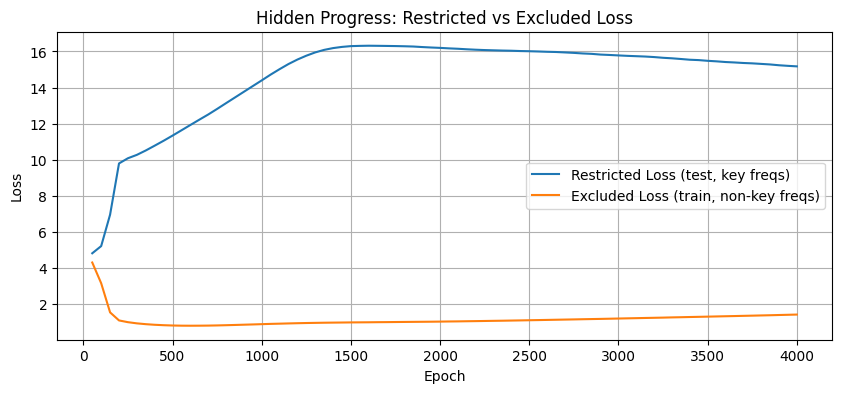

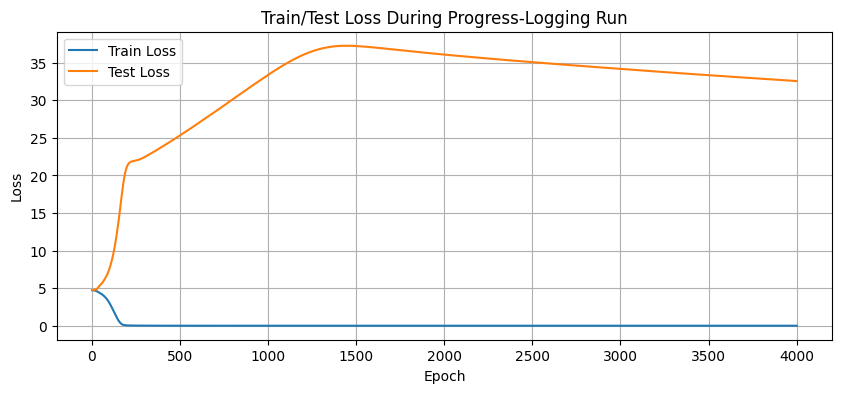

In [18]:
plt.figure(figsize=(10,4))
plt.plot(prog_epochs, prog_restricted_losses, label="Restricted Loss (test, key freqs)")
plt.plot(prog_epochs, prog_excluded_losses, label="Excluded Loss (train, non-key freqs)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Hidden Progress: Restricted vs Excluded Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(np.arange(1, EPOCHS_PROGRESS+1), prog_train_losses, label="Train Loss")
plt.plot(np.arange(1, EPOCHS_PROGRESS+1), prog_test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Test Loss During Progress-Logging Run")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# Start from FINAL grokked model (model_add) and WE/fourier_WE from Cell 8

def evaluate_with_new_WE(WE_full_tensor):
    """Replace W_E temporarily, evaluate train/test accuracy."""
    backup = model_add.W_E.data.clone()
    model_add.W_E.data = WE_full_tensor

    with torch.no_grad():
        logits_train = model_add(train_X_add)[:, -1, :]
        logits_test  = model_add(test_X_add)[:, -1, :]

        train_acc = (logits_train.argmax(dim=-1) == train_Y_add).float().mean().item()
        test_acc  = (logits_test.argmax(dim=-1)  == test_Y_add).float().mean().item()

    model_add.W_E.data = backup
    return train_acc, test_acc

# 1) Zero out MOST DOMINANT key frequency only
dominant = key_freqs[-1]
mask_keep_all_but_dominant = np.ones(P, dtype=bool)
mask_keep_all_but_dominant[dominant] = False

fourier_abl1 = np.where(mask_keep_all_but_dominant[:, None], fourier_WE, 0)
WE_abl1 = np.fft.ifft(fourier_abl1, axis=0).real
WE_abl1_full = WE_full.copy()
WE_abl1_full[:P] = WE_abl1
WE_abl1_tensor = torch.tensor(WE_abl1_full, dtype=torch.float32, device=device)

acc_train_abl1, acc_test_abl1 = evaluate_with_new_WE(WE_abl1_tensor)
print("Ablation 1 (remove dominant key freq): train acc =", acc_train_abl1, "test acc =", acc_test_abl1)

# 2) Keep ONLY key frequencies → ablate > 90% of weights in Fourier space
keep_mask = np.zeros(P, dtype=bool)
keep_mask[key_freqs] = True

fourier_abl2 = np.where(keep_mask[:, None], fourier_WE, 0)
WE_abl2 = np.fft.ifft(fourier_abl2, axis=0).real
WE_abl2_full = WE_full.copy()
WE_abl2_full[:P] = WE_abl2
WE_abl2_tensor = torch.tensor(WE_abl2_full, dtype=torch.float32, device=device)

acc_train_abl2, acc_test_abl2 = evaluate_with_new_WE(WE_abl2_tensor)
print("Ablation 2 (keep ONLY key freqs): train acc =", acc_train_abl2, "test acc =", acc_test_abl2)


Ablation 1 (remove dominant key freq): train acc = 0.9853785634040833 test acc = 0.021926390007138252
Ablation 2 (keep ONLY key freqs): train acc = 0.1054830253124237 test acc = 0.07674236595630646


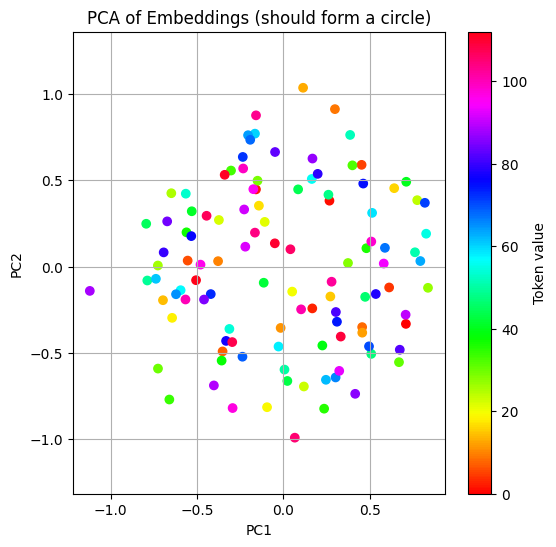

In [20]:
pca = PCA(n_components=2)
proj = pca.fit_transform(WE)    # WE is (P, d_model) for tokens 0..P-1

plt.figure(figsize=(6,6))
scatter = plt.scatter(proj[:,0], proj[:,1], c=np.arange(P), cmap="hsv")
plt.colorbar(scatter, label="Token value")
plt.title("PCA of Embeddings (should form a circle)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.axis("equal")
plt.grid(True)
plt.show()


In [21]:
def make_sub_dataset(pair_list, p=P):
    X, Y = [], []
    for a, b in pair_list:
        X.append([a, b, EQ_TOKEN])
        Y.append((a - b) % p)
    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    return X.to(device), Y.to(device)

train_X_sub, train_Y_sub = make_sub_dataset(train_pairs_add)
test_X_sub,  test_Y_sub  = make_sub_dataset(test_pairs_add)

# New model for subtraction
set_seed()
model_sub = HookedTransformer(cfg).to(device)
for name, param in model_sub.named_parameters():
    if "bias" in name:
        param.requires_grad = False

optimizer_sub = torch.optim.AdamW(
    model_sub.parameters(),
    lr=1e-3, betas=(0.9, 0.98), weight_decay=1.0
)

EPOCHS_SUB = 8000  # adjust for convergence

sub_train_losses, sub_test_losses = [], []
sub_train_accs, sub_test_accs = [], []

for epoch in tqdm(range(EPOCHS_SUB)):
    model_sub.train()
    logits = model_sub(train_X_sub)[:, -1, :]
    loss = high_precision_ce(logits, train_Y_sub)

    optimizer_sub.zero_grad()
    loss.backward()
    optimizer_sub.step()

    with torch.no_grad():
        model_sub.eval()
        train_pred = logits.argmax(dim=-1)
        train_acc = (train_pred == train_Y_sub).float().mean().item()

        test_logits = model_sub(test_X_sub)[:, -1, :]
        test_loss = high_precision_ce(test_logits, test_Y_sub)
        test_pred = test_logits.argmax(dim=-1)
        test_acc = (test_pred == test_Y_sub).float().mean().item()

    sub_train_losses.append(loss.item())
    sub_test_losses.append(test_loss.item())
    sub_train_accs.append(train_acc)
    sub_test_accs.append(test_acc)

    if (epoch + 1) % 500 == 0:
        print(f"[Sub] Epoch {epoch+1} Train acc {train_acc:.3f} Test acc {test_acc:.3f}")

print("Final subtraction train/test acc:", sub_train_accs[-1], sub_test_accs[-1])


Moving model to device:  cuda


  6%|▋         | 505/8000 [00:10<02:29, 50.01it/s]

[Sub] Epoch 500 Train acc 1.000 Test acc 0.001


 13%|█▎        | 1006/8000 [00:20<02:21, 49.33it/s]

[Sub] Epoch 1000 Train acc 1.000 Test acc 0.002


 19%|█▉        | 1507/8000 [00:30<02:11, 49.25it/s]

[Sub] Epoch 1500 Train acc 1.000 Test acc 0.001


 25%|██▌       | 2009/8000 [00:40<02:01, 49.39it/s]

[Sub] Epoch 2000 Train acc 1.000 Test acc 0.002


 31%|███▏      | 2507/8000 [00:50<01:52, 49.01it/s]

[Sub] Epoch 2500 Train acc 1.000 Test acc 0.002


 38%|███▊      | 3008/8000 [01:01<01:42, 48.55it/s]

[Sub] Epoch 3000 Train acc 1.000 Test acc 0.002


 44%|████▍     | 3509/8000 [01:11<01:30, 49.40it/s]

[Sub] Epoch 3500 Train acc 1.000 Test acc 0.002


 50%|█████     | 4006/8000 [01:21<01:20, 49.49it/s]

[Sub] Epoch 4000 Train acc 1.000 Test acc 0.002


 56%|█████▋    | 4507/8000 [01:31<01:10, 49.57it/s]

[Sub] Epoch 4500 Train acc 1.000 Test acc 0.003


 63%|██████▎   | 5009/8000 [01:41<01:00, 49.50it/s]

[Sub] Epoch 5000 Train acc 1.000 Test acc 0.003


 69%|██████▉   | 5505/8000 [01:51<00:50, 49.23it/s]

[Sub] Epoch 5500 Train acc 1.000 Test acc 0.003


 75%|███████▌  | 6006/8000 [02:02<00:41, 47.63it/s]

[Sub] Epoch 6000 Train acc 1.000 Test acc 0.003


 81%|████████▏ | 6509/8000 [02:12<00:30, 49.47it/s]

[Sub] Epoch 6500 Train acc 1.000 Test acc 0.004


 88%|████████▊ | 7008/8000 [02:22<00:20, 49.30it/s]

[Sub] Epoch 7000 Train acc 1.000 Test acc 0.005


 94%|█████████▍| 7508/8000 [02:32<00:09, 49.61it/s]

[Sub] Epoch 7500 Train acc 1.000 Test acc 0.006


100%|██████████| 8000/8000 [02:42<00:00, 49.13it/s]

[Sub] Epoch 8000 Train acc 1.000 Test acc 0.006
Final subtraction train/test acc: 1.0 0.005929075181484222


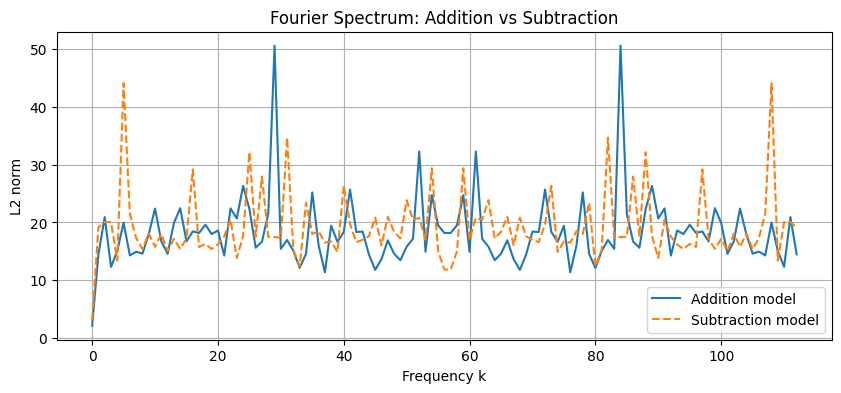

Subtraction key frequencies: [  5  31  82 108]


In [22]:
with torch.no_grad():
    WE_sub_full = model_sub.W_E.detach().cpu().numpy()
WE_sub = WE_sub_full[:P]

fourier_WE_sub = np.fft.fft(WE_sub, axis=0)
freq_magnitudes_sub = np.linalg.norm(fourier_WE_sub, axis=1)

plt.figure(figsize=(10,4))
plt.plot(freq_magnitudes, label="Addition model")
plt.plot(freq_magnitudes_sub, label="Subtraction model", linestyle="--")
plt.xlabel("Frequency k")
plt.ylabel("L2 norm")
plt.title("Fourier Spectrum: Addition vs Subtraction")
plt.legend()
plt.grid(True)
plt.show()

# Top freqs for subtraction
key_freqs_sub = np.argsort(freq_magnitudes_sub)[-TOP_K:]
key_freqs_sub = np.sort(key_freqs_sub)
print("Subtraction key frequencies:", key_freqs_sub)


In [23]:
# Choose one key frequency from subtraction model
k_sub = int(key_freqs_sub[-1])
omega = 2 * np.pi * k_sub / P

def trig_features_for_pairs(pair_list):
    a_vals = np.array([a for (a, b) in pair_list])
    b_vals = np.array([b for (a, b) in pair_list])

    cos_a = np.cos(omega * a_vals)
    cos_b = np.cos(omega * b_vals)
    sin_a = np.sin(omega * a_vals)
    sin_b = np.sin(omega * b_vals)

    # target trig signals
    add_style = cos_a * cos_b - sin_a * sin_b
    sub_style = cos_a * cos_b + sin_a * sin_b

    return add_style, sub_style

# Use a subset of pairs for correlation
sample_pairs = train_pairs_add[:500]
add_style, sub_style = trig_features_for_pairs(sample_pairs)

X_sub_sample, _ = make_sub_dataset(sample_pairs)
_, cache_sub = model_sub.run_with_cache(X_sub_sample)

# Use final residual stream at output token as a representation
resid_post_sub = cache_sub["blocks.0.hook_resid_post"][:, -1, :]  # (B, d_model)
# Project onto some random direction or first PCA dir as a scalar signal
resid_np = resid_post_sub.detach().cpu().numpy()
pca_local = PCA(n_components=1)
proj_scalar = pca_local.fit_transform(resid_np).squeeze()   # (B,)

# Compute Pearson correlations with trig expressions
def corr(x, y):
    x = x - x.mean()
    y = y - y.mean()
    return (x * y).sum() / (np.sqrt((x*x).sum()) * np.sqrt((y*y).sum()) + 1e-8)

corr_add = corr(proj_scalar, add_style)
corr_sub = corr(proj_scalar, sub_style)

print(f"Correlation with cos(wa)cos(wb) - sin(wa)sin(wb): {corr_add:.4f}")
print(f"Correlation with cos(wa)cos(wb) + sin(wa)sin(wb): {corr_sub:.4f}")


Correlation with cos(wa)cos(wb) - sin(wa)sin(wb): 0.1192
Correlation with cos(wa)cos(wb) + sin(wa)sin(wb): 0.0155


In [24]:
def get_flat_params(model):
    return torch.cat([p.view(-1) for p in model.parameters() if p.requires_grad])

def set_flat_params(model, flat):
    idx = 0
    for p in model.parameters():
        if p.requires_grad:
            num = p.numel()
            p.data.copy_(flat[idx:idx+num].view_as(p))
            idx += num

def hvp(model, loss_fn, inputs, targets, vec):
    """
    Hessian-vector product using double backprop.
    vec is a flat vector (same size as all params requiring grad).
    """
    model.zero_grad(set_to_none=True)
    # Compute loss
    logits = model(inputs)[:, -1, :]
    loss = loss_fn(logits, targets)

    params = [p for p in model.parameters() if p.requires_grad]
    grad = torch.autograd.grad(loss, params, create_graph=True)

    flat_grad = torch.cat([g.reshape(-1) for g in grad])
    hv = torch.autograd.grad((flat_grad * vec).sum(), params)
    flat_hv = torch.cat([h.reshape(-1) for h in hv])
    return flat_hv

def top_k_eigenvalues(model, inputs, targets, k=3, iters=20):
    """
    Very rough estimate of top-k eigenvalues using
    power iteration + simple deflation.
    """
    model.eval()
    params = [p for p in model.parameters() if p.requires_grad]
    dim = sum(p.numel() for p in params)

    eigenvalues = []
    eigenvectors = []

    for j in range(k):
        v = torch.randn(dim, device=device)
        v = v / (v.norm() + 1e-8)

        for _ in range(iters):
            # deflate against previous eigenvectors
            for prev_v in eigenvectors:
                proj = (v * prev_v).sum()
                v = v - proj * prev_v
            v = v / (v.norm() + 1e-8)

            hv = hvp(model, high_precision_ce, inputs, targets, v)

            # again orthogonalize
            for prev_v in eigenvectors:
                proj = (hv * prev_v).sum()
                hv = hv - proj * prev_v

            v = hv / (hv.norm() + 1e-8)

        # Rayleigh quotient
        hv = hvp(model, high_precision_ce, inputs, targets, v)
        lam = (v * hv).sum().item()
        eigenvalues.append(lam)
        eigenvectors.append(v.detach())

        print(f"Eigenvalue {j+1}: {lam:.4e}")

    return eigenvalues, eigenvectors

# Example: compute on a small random subset for current addition model
subset_idx = torch.randperm(train_X_add.size(0))[:256]
batch_X = train_X_add[subset_idx]
batch_Y = train_Y_add[subset_idx]

eigs_now, _ = top_k_eigenvalues(model_add, batch_X, batch_Y, k=3, iters=10)
print("Approx top-3 eigenvalues at current checkpoint:", eigs_now)


Eigenvalue 1: 4.2802e-04
Eigenvalue 2: 3.5454e-04
Eigenvalue 3: 3.2846e-04
Approx top-3 eigenvalues at current checkpoint: [0.0004280162393115461, 0.0003545412910170853, 0.0003284632111899555]
